In [1]:
# -*- coding: utf-8 -*-
# author: Yabin Zheng
# Email: sczhengyabin@hotmail.com

import re
from bs4 import BeautifulSoup
from concurrent import futures
import sys
import time
import pandas as pd
import requests
import json
from fake_useragent import UserAgent

In [2]:
HEADERS = {}

In [3]:
# 多线程数量设置
NUM_THREADS = 16

city_dict = {"成都": "cd", "北京": "bj", "上海": "sh", "广州": "gz", "深圳": "sz", "南京": "nj", "合肥": "hf", "杭州": "hz", }
CITY = city_dict["北京"]

# 是否打印 HTTP error
PRINT = False
proxies = None
ua = UserAgent()

# 代理设置

In [4]:
PROXY_HOST = "proxy.abuyun.com"
PROXY_PORT = "9020"
PROXY_USERNAME = 'H99H75AT4V8D761D'
PROXY_PASSWORD = '9EEDC185780C0189'

def gen_proxies_from_cert(proxy_user, proxy_password):
    proxy_meta = "http://%(user)s:%(pass)s@%(host)s:%(port)s" % {
        "host" : PROXY_HOST,
        "port" : PROXY_PORT,
        "user" : proxy_user,
        "pass" : proxy_password
    }

    proxies = {
        "http"  : proxy_meta,
        "https" : proxy_meta
    }

    return proxies

abuyun_proxies = gen_proxies_from_cert(PROXY_USERNAME, PROXY_PASSWORD)
proxies = abuyun_proxies

# 函数定义

In [5]:
""" Get 操作封装 """
def get_bs_obj_from_url(http_url):
    done = False
    exception_time = 0
    HEADERS["User-Agent"] = ua.random
    while not done:
        try:
            if PRINT:
                print("正在获取 {}".format(http_url))
            r = requests.get(http_url, headers=HEADERS, proxies=proxies)
            bs_obj = BeautifulSoup(r.text, "html.parser")
            done = True
        except Exception as e:
            if PRINT:
                print(e)
            exception_time += 1
            time.sleep(1)
            if exception_time > 10:
                return None
    return bs_obj

In [6]:
""" 获取城市的行政区域列表 """
def get_district_from_city(city):
    print("********** 获取城市的行政区域: {} **********".format(city))
    city_url = "http://{}.lianjia.com".format(city)
    http_url = city_url + "/xiaoqu"
    bs_obj = get_bs_obj_from_url(http_url)
    
    parent_div = bs_obj.find("div", {"data-role": "ershoufang"})
    a_list = parent_div.find_all("a")
    
    district_list = [a.attrs["href"].replace("/xiaoqu/", "")[:-1] 
                         for a in a_list
                         if a.attrs['href'].startswith("/xiaoqu")]
    
    print("########## 总共 {} 个行政区域 ##########".format(len(district_list)))
    
    return district_list

In [7]:
""" 获取一个行政区域的所有小区ID列表 """
def get_xiaoqu_from_district(city, district):
    xiaoqu_list = []
    http_url = "http://{}.lianjia.com/xiaoqu/{}".format(city, district)
    exception_time = 0
    done = False
    while not done:
        try:
            bs_obj = get_bs_obj_from_url(http_url)
            total_pages = int(json.loads(bs_obj.find("div", {"class": "page-box house-lst-page-box"}).attrs["page-data"])["totalPage"])
            total_xiaoqu_num = int(bs_obj.find("h2", {"class": "total fl"}).find("span").get_text())
            done = True
        except Exception as e:
            exception_time += 1
            if exception_time > 10:
                return xiaoqu_list

    with futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
        future_list = []
        for page_no in range(1, total_pages + 1):
            future_list.append(executor.submit(get_xiaoqu_in_page, city, district, page_no))
        fail_list = []
        count = 0
        for future in futures.as_completed(future_list):
            page_no, xiaoqu_list_partial = future.result()
            if xiaoqu_list_partial is None or len(xiaoqu_list_partial) == 0:
                fail_list.append(page_no)
            else:
                xiaoqu_list += xiaoqu_list_partial
                count += 1
                sys.stdout.write("\r当前行政区域 {} 已完成: {}/{}".format(
                    district, count, total_pages))
        for page_no in fail_list:
            page_no, xiaoqu_list_partial = get_xiaoqu_in_page(city, district, page_no)
            if xiaoqu_list_partial is not None and len(xiaoqu_list_partial) > 0:
                xiaoqu_list += xiaoqu_list_partial
            count += 1
            sys.stdout.write("\r当前行政区域 {} 已完成: {}/{}".format(
                district, count, total_pages))
    print("")
    return xiaoqu_list

In [8]:
""" 获取一个行政区域某一页的小区列表 """
def get_xiaoqu_in_page(city, district, page_no):
    http_url = "http://{}.lianjia.com/xiaoqu/{}/pg{}".format(city, district, page_no)
    bs_obj = get_bs_obj_from_url(http_url)
    
    if bs_obj is None:
        return None
    
    parent_list = bs_obj.find_all("li", {"class": "clear xiaoquListItem"})
    
    xiaoqu_list = []
    
    if not (len(parent_list) == 0):
        for li in parent_list:
            xiaoqu_url = li.find("div", {"class": "title"}).find("a").attrs["href"]
            xiaoqu_id = "".join(list(filter(str.isdigit, xiaoqu_url)))
            xiaoqu_list.append(xiaoqu_id)
    return page_no, xiaoqu_list

In [9]:
""" 获取一个城市的所有小区ID列表 """
def get_xiaoqu_of_city(city):
    district_list = get_district_from_city(city)
    xiaoqu_list = []
    for district in district_list:
        xiaoqu_of_district = get_xiaoqu_from_district(city, district)
        xiaoqu_list += xiaoqu_of_district
        print("****** 当前行政区域 {} 的小区数: {}, 总小区数: {} ******".format(
            district, len(xiaoqu_of_district), len(xiaoqu_list)))
    return xiaoqu_list

In [10]:
""" 根据小区ID获取小区详细信息 """
def get_xiaoqu_info(city, xiaoqu_id):
    http_url = "http://{}.lianjia.com/xiaoqu/{}".format(city, xiaoqu_id)
    bs_obj = get_bs_obj_from_url(http_url)
    
    df = pd.DataFrame()
    
    if bs_obj is not None:
        try:
            location_list = bs_obj.find("div", {"class": "fl l-txt"}).find_all("a")
            info_city = location_list[1].get_text().replace("小区", "")
            info_district = location_list[2].get_text().replace("小区", "")
            info_area = location_list[3].get_text().replace("小区", "")
            info_name = location_list[4].get_text()

            if bs_obj.find("span", {"class": "xiaoquUnitPrice"}) is not None:
                info_price = bs_obj.find("span", {"class": "xiaoquUnitPrice"}).get_text()
            else:
                info_price = "暂无报价"

            info_address = bs_obj.find("div", {"class": "detailDesc"}).get_text()

            info_list = bs_obj.find_all("span", {"class": "xiaoquInfoContent"})
            info_year = info_list[0].get_text().replace("年建成", "")
            info_type = info_list[1].get_text()
            info_property_fee = info_list[2].get_text()
            info_property_company = info_list[3].get_text()
            info_developer_company = info_list[4].get_text()
            info_building_num = info_list[5].get_text().replace("栋", "")
            info_house_num = info_list[6].get_text().replace("户", "")

            df = pd.DataFrame(data=[[xiaoqu_id, http_url, info_name, info_city,
                                     info_district, info_area, info_price, info_year,
                                     info_building_num, info_house_num, info_developer_company, info_property_fee,
                                     info_property_company, info_type, info_address]],
                              columns=["ID", "URL", "小区名称", "城市",
                                       "区域", "片区", "参考均价", "建筑年代",
                                       "总栋数", "总户数", "开发商","物业费",
                                       "物业公司", "建筑类型", "地址"])
        except Exception as e:
            print(e)

    return xiaoqu_id, df

In [11]:
""" 根据城市和小区ID列表，获取所有小区的详细信息 """
def get_xiaoqu_info_from_xiaoqu_list(city, xiaoqu_list):
    df_xiaoqu_info = pd.DataFrame()
    count = 0
    pct = 0
    
    with futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
        future_list = []
        for xiaoqu in xiaoqu_list:
            future_list.append(executor.submit(get_xiaoqu_info, city, xiaoqu))
        fail_list = []
        print(" ")
        for future in futures.as_completed(future_list):
            xiaoqu, df_info_partial = future.result()
            if len(df_info_partial) == 0:
                fail_list.append(xiaoqu)
            else:
                df_xiaoqu_info = df_xiaoqu_info.append(df_info_partial)
                count += 1
                sys.stdout.write("\r获取小区信息: {}/{}".format(count, len(xiaoqu_list)))
        for page_no in fail_list:
            xiaoqu, df_info_partial = get_xiaoqu_info(city, xiaoqu)
            if len(df_info_partial) > 0:
                df_xiaoqu_info = df_xiaoqu_info.append(df_info_partial)
                count += 1
        sys.stdout.write("\r获取小区信息: {}/{}".format(count, len(xiaoqu_list)))

    return df_xiaoqu_info

In [19]:
""" 获取小区成交记录的某一页的内容 """
def get_xiaoqu_transactions_in_page(city, xiaoqu_id, page_no):
    http_url = "http://{}.lianjia.com/chengjiao/pg{}c{}/".format(city, page_no, xiaoqu_id)
    bs_obj = get_bs_obj_from_url(http_url)
    
    df = pd.DataFrame()
    
    if bs_obj is not None:
        try:
            div_list = bs_obj.find_all("div", {"class": "info"})
            
            for div in div_list:
                div_title = div.find("div", {"class": "title"}).find("a")
                url = div_title.attrs["href"]
                trans_id = url[url.rfind('/')+1:url.rfind('.')]
                title_strs = div_title.get_text().split(" ")
                xiaoqu_name = title_strs[0]
                house_type = title_strs[1]
                built_area = title_strs[2].replace("平米", "")
                
                house_info_strs = div.find("div", {"class": "houseInfo"}).get_text().replace(" ", "").split("|")
                direction = house_info_strs[0]
                decoration = house_info_strs[1].replace("&nbsp;", "")
                if len(house_info_strs) == 3:
                    elevator = house_info_strs[2].replace("电梯", "")
                else:
                    elevator = ""
                
                deal_date = div.find("div", {"class": "dealDate"}).get_text()
                deal_price = div.find("div", {"class": "totalPrice"}).find("span", {"class": "number"}).get_text()
                
                position_info_strs = div.find("div", {"class": "positionInfo"}).get_text().split(" ")
                floor = position_info_strs[0]
                build_year = int(position_info_strs[1].split("年建")[0]) if "年建" in position_info_strs[1] else ""
                build_type = position_info_strs[1].split("年建")[1] if "年建" in position_info_strs[1] else position_info_strs[1]
                
                unit_price = div.find("div", {"class": "unitPrice"}).find("span", {"class": "number"}).get_text()
                
                span_deal_cycle = div.find("span", {"class": "dealCycleTxt"}).find_all("span")
                if len(span_deal_cycle) == 2:
                    list_price = "".join(list(filter(lambda x: str.isdigit(x) or (x == "."), span_deal_cycle[0].get_text())))
                    deal_cycle = "".join(list(filter(str.isdigit, span_deal_cycle[1].get_text())))
                else:
                    deal_cycle = "".join(list(filter(str.isdigit, span_deal_cycle[0].get_text())))
                    list_price = ""
                    
                
                temp_df = pd.DataFrame(data=[[trans_id, xiaoqu_id, xiaoqu_name, house_type, 
                                              built_area, deal_price, list_price, unit_price, 
                                              deal_cycle, deal_date, direction, decoration, 
                                              elevator, floor, build_year, build_type]], 
                                       columns=["成交记录ID", "小区ID", "小区名称", "户型", 
                                                "建筑面积", "成交价", "挂牌价", "单价",
                                                "成交周期", "成交日期", "朝向", "装修",
                                                "电梯", "楼层", "建筑年份", "建筑类型",])
                df = df.append(temp_df)
            
        except Exception as e:
            print(xiaoqu_id, page_no, e)
    
    return df

""" 获取小区所有的成交记录 """
def get_xiaoqu_transactions(city, xiaoqu_id):    
    df_xiaoqu_transctions = pd.DataFrame()
    
    for i in range(3):
        try:
            http_url = "http://{}.lianjia.com/chengjiao/c{}/".format(city, xiaoqu_id)
            bs_obj = get_bs_obj_from_url(http_url)
            total_transaction_num = int(bs_obj.find("div", {"class": "total fl"}).find("span").get_text())
            if total_transaction_num == 0:
                return df_xiaoqu_transctions
            total_pages = int(json.loads(bs_obj.find("div", {"class": "page-box house-lst-page-box"}).attrs["page-data"])["totalPage"])
            
            break
        except Exception as e:
            print(xiaoqu_id, e)
            if i == 4:
                return df_xiaoqu_transctions
        
    fail_list = []
    for page_no in range(1, total_pages+1):
        xiaoqu_transactions_partial = get_xiaoqu_transactions_in_page(city, xiaoqu_id, page_no)
        if xiaoqu_transactions_partial is None or len(xiaoqu_transactions_partial) == 0:
            fail_list.append(page_no)
        else:
            df_xiaoqu_transctions = df_xiaoqu_transctions.append(xiaoqu_transactions_partial) 
    for page_no in fail_list:
        xiaoqu_transactions_partial = get_xiaoqu_transactions_in_page(city, xiaoqu_id, page_no)
        if xiaoqu_transactions_partial is not None and len(xiaoqu_transactions_partial) > 0:
            df_xiaoqu_transctions = df_xiaoqu_transctions.append(xiaoqu_transactions_partial)        
    return df_xiaoqu_transctions    

In [20]:
""" 根据小区ID列表，获取所有小区的所有成交记录 """
def get_transactions_from_xiaoqu_list(city, xiaoqu_list):
    df = pd.DataFrame()
    print(" ")
    
    with futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
        future_list = []
        for xiaoqu in xiaoqu_list:
            future_list.append(executor.submit(get_xiaoqu_transactions, city, xiaoqu))
        fail_list = []
        count = 0
        for future in futures.as_completed(future_list):
            if future.exception() is not None:
                print(future.exception())
            else:
                xiaoqu_transactions_partial = future.result()
                df = df.append(xiaoqu_transactions_partial)    
            count += 1
            sys.stdout.write("\rProgress: {}/{}".format(count, len(xiaoqu_list)))
    return df

# 爬取城市的小区ID列表

In [12]:
xiaoqu_list = get_xiaoqu_of_city(CITY)

********** 获取城市的行政区域: bj **********
########## 总共 17 个行政区域 ##########
当前行政区域 dongcheng 已完成: 38/38
****** 当前行政区域 dongcheng 的小区数: 1131, 总小区数: 1131 ******
当前行政区域 xicheng 已完成: 54/54
****** 当前行政区域 xicheng 的小区数: 1594, 总小区数: 2725 ******
当前行政区域 chaoyang 已完成: 58/58
****** 当前行政区域 chaoyang 的小区数: 1727, 总小区数: 4452 ******
当前行政区域 haidian 已完成: 56/56
****** 当前行政区域 haidian 的小区数: 1656, 总小区数: 6108 ******
当前行政区域 fengtai 已完成: 39/39
****** 当前行政区域 fengtai 的小区数: 1153, 总小区数: 7261 ******
当前行政区域 shijingshan 已完成: 8/8
****** 当前行政区域 shijingshan 的小区数: 218, 总小区数: 7479 ******
当前行政区域 tongzhou 已完成: 21/21
****** 当前行政区域 tongzhou 的小区数: 610, 总小区数: 8089 ******
当前行政区域 changping 已完成: 24/24
****** 当前行政区域 changping 的小区数: 715, 总小区数: 8804 ******
当前行政区域 daxing 已完成: 15/15
****** 当前行政区域 daxing 的小区数: 427, 总小区数: 9231 ******
当前行政区域 yizhuangkaifaqu 已完成: 4/4
****** 当前行政区域 yizhuangkaifaqu 的小区数: 95, 总小区数: 9326 ******
当前行政区域 shunyi 已完成: 11/11
****** 当前行政区域 shunyi 的小区数: 306, 总小区数: 9632 ******
当前行政区域 fangshan 已完成: 18/18
****** 当前行政区域 fangshan 的

In [13]:
with open("{}_list.txt".format(CITY), mode="w") as f:
    for xiaoqu in xiaoqu_list:
        f.write(xiaoqu + "\n")
print("list write finished.")

list write finished.


## 从文件读取小区ID列表

In [14]:
with open("{}_list.txt".format(CITY), mode="r") as f:
    xiaoqu_list = [line[:-1] for line in f.readlines()]

# 爬取小区ID列表对应的小区信息

In [15]:
df_xiaoqu_info = get_xiaoqu_info_from_xiaoqu_list(CITY, xiaoqu_list)

 
获取小区信息: 119/10522'NoneType' object has no attribute 'find_all'
获取小区信息: 194/10522'NoneType' object has no attribute 'find_all'
'NoneType' object has no attribute 'find_all'
获取小区信息: 512/10522'NoneType' object has no attribute 'find_all'
获取小区信息: 584/10522'NoneType' object has no attribute 'find_all'
获取小区信息: 1325/10522'NoneType' object has no attribute 'find_all'
获取小区信息: 1779/10522'NoneType' object has no attribute 'find_all'
获取小区信息: 2172/10522'NoneType' object has no attribute 'find_all'
获取小区信息: 2316/10522'NoneType' object has no attribute 'find_all'
获取小区信息: 2592/10522'NoneType' object has no attribute 'find_all'
获取小区信息: 2629/10522'NoneType' object has no attribute 'find_all'
获取小区信息: 2687/10522'NoneType' object has no attribute 'find_all'
获取小区信息: 3158/10522'NoneType' object has no attribute 'find_all'
获取小区信息: 3370/10522'NoneType' object has no attribute 'find_all'
获取小区信息: 3377/10522'NoneType' object has no attribute 'find_all'
获取小区信息: 3546/10522'NoneType' object has no attribute 'find_a

In [18]:
# 保存为UTF8 CSV
df_xiaoqu_info.to_csv("{}_info.csv".format(CITY), sep=",", encoding="utf-8")

# 保存为Excel
writer = pd.ExcelWriter("{}_info.xlsx".format(CITY))
df_xiaoqu_info.to_excel(writer, "小区信息")
writer.save()

print("infos write finished.")

infos write finished.


# 爬取二手房交易记录

In [21]:
# 分段爬取，避免失败重新爬，根据具体情况设置PART的值
PART = 10
df_transactions = pd.DataFrame()
for i in range(0, PART):
    start = int(i * len(xiaoqu_list) / PART)
    end = int((i + 1) * len(xiaoqu_list) / PART)
    df_transactions = df_transactions.append(get_transactions_from_xiaoqu_list(CITY, xiaoqu_list[start:end]))
    writer = pd.ExcelWriter("{}_transactions_{}.xlsx".format(CITY, i+1))
    df_transactions.to_excel(writer, "Data")
    writer.save()
#     df_transactions.to_csv("{}_transaction_{}.csv".format(CITY, i+1), sep=",", encoding="utf-8")
    print("\nfile {} written.".format(i+1))

 
1111027376532 1 'NoneType' object has no attribute 'get_text'
1111027378078 11111027380693 1 'NoneType' object has no attribute 'get_text'
 'NoneType' object has no attribute 'get_text'
1111027378766 1 'NoneType' object has no attribute 'get_text'
1111027379801 1 'NoneType' object has no attribute 'get_text'
1111027380693 2 'NoneType' object has no attribute 'get_text'
1111027378078 2 'NoneType' object has no attribute 'get_text'
1111027375691 1 'NoneType' object has no attribute 'get_text'
1111027375663 1 'NoneType' object has no attribute 'get_text'
1111027381407 11111027378766  'NoneType' object has no attribute 'get_text'
2 'NoneType' object has no attribute 'get_text'1111027379801
 2 'NoneType' object has no attribute 'get_text'
1111027380693 1 'NoneType' object has no attribute 'get_text'
1111027376532 2 'NoneType' object has no attribute 'get_text'
Progress: 1/10521 'NoneType' object has no attribute 'get_text'
1111043313490 1 'NoneType' object has no attribute 'get_text'
1111

1111027374689 4 'NoneType' object has no attribute 'get_text'
1111027377234 2 'NoneType' object has no attribute 'get_text'
1111027374216 2 'NoneType' object has no attribute 'get_text'
1111027375204 2 'NoneType' object has no attribute 'get_text'
1111027374953 1 'NoneType' object has no attribute 'get_text'
Progress: 33/10521111027374074 2 'NoneType' object has no attribute 'get_text'
1111027377023 1 'NoneType' object has no attribute 'get_text'
1111027381367 3 'NoneType' object has no attribute 'get_text'
1111043316306 1 'NoneType' object has no attribute 'get_text'1111027375656
 1 'NoneType' object has no attribute 'get_text'
1111027378887 1 'NoneType' object has no attribute 'get_text'
1111027373924 1 'NoneType' object has no attribute 'get_text'
1111027374216 3 'NoneType' object has no attribute 'get_text'
1111027381367 4 'NoneType' object has no attribute 'get_text'
Progress: 34/10521111027374953 2 'NoneType' object has no attribute 'get_text'
Progress: 36/1052'NoneType' object h

Progress: 66/10521111027377502 3 'NoneType' object has no attribute 'get_text'
Progress: 67/10526 'NoneType' object has no attribute 'get_text'
Progress: 68/10521111027374080 4 'NoneType' object has no attribute 'get_text'
1111027375464 1 'NoneType' object has no attribute 'get_text'
Progress: 69/10521111027374690 3 'NoneType' object has no attribute 'get_text'
Progress: 70/10521111027374671 1 'NoneType' object has no attribute 'get_text'
1111027374755 1 'NoneType' object has no attribute 'get_text'
Progress: 71/10521111027374080 1 'NoneType' object has no attribute 'get_text'
Progress: 72/10521111027381014 1 'NoneType' object has no attribute 'get_text'
Progress: 73/10521111027374080 2 'NoneType' object has no attribute 'get_text'
1111041129296 1 'NoneType' object has no attribute 'get_text'
Progress: 74/10521111027379719 1 'NoneType' object has no attribute 'get_text'
Progress: 75/10521111027374671 2 'NoneType' object has no attribute 'get_text'
Progress: 76/10521111027378095 1 'None

Progress: 141/10521111027374784 1 'NoneType' object has no attribute 'get_text'
Progress: 142/10521111027377140 1 'NoneType' object has no attribute 'get_text'
Progress: 144/10521111027380094 1 'NoneType' object has no attribute 'get_text'
Progress: 146/10521111027377412 1 'NoneType' object has no attribute 'get_text'
1111027380093 1 'NoneType' object has no attribute 'get_text'
Progress: 147/10521111027378498 2 'NoneType' object has no attribute 'get_text'
Progress: 149/10521111027377412 1 'NoneType' object has no attribute 'get_text'
Progress: 152/10521111027376753 1 'NoneType' object has no attribute 'get_text'
1111027380028 1 'NoneType' object has no attribute 'get_text'
Progress: 155/10521111027376753 1 'NoneType' object has no attribute 'get_text'
Progress: 156/10521111027380545 1 'NoneType' object has no attribute 'get_text'
Progress: 158/10521111027381012 1 'NoneType' object has no attribute 'get_text'
Progress: 160/10521111027378459 1 'NoneType' object has no attribute 'get_te

1111043314469 4 'NoneType' object has no attribute 'get_text'
Progress: 217/1052 'NoneType' object has no attribute 'get_text'
1111027381164 1 'NoneType' object has no attribute 'get_text'
1111027379462 1 'NoneType' object has no attribute 'get_text'
1111027380911 5 'NoneType' object has no attribute 'get_text'
1111027374993 1 'NoneType' object has no attribute 'get_text'
1111027377501 1 'NoneType' object has no attribute 'get_text'
1111027376748 3 'NoneType' object has no attribute 'get_text'
1111043315856 4 'NoneType' object has no attribute 'get_text'
1111027375114 1 'NoneType' object has no attribute 'get_text'
1111027380911 6 'NoneType' object has no attribute 'get_text'
1111027374220 2 'NoneType' object has no attribute 'get_text'
1111027376748 4 'NoneType' object has no attribute 'get_text'
111102737520311110273794621111027377077  12  'NoneType' object has no attribute 'get_text''NoneType' object has no attribute 'get_text' 

2 'NoneType' object has no attribute 'get_text'
11110

1111027376212 'NoneType' object has no attribute 'find'
1111027374052 1 'NoneType' object has no attribute 'get_text'
1111027376665 2 'NoneType' object has no attribute 'get_text'
1111027373685 4 'NoneType' object has no attribute 'get_text'
1111027375265 5 'NoneType' object has no attribute 'get_text'
1111027379915 1 'NoneType' object has no attribute 'get_text'
1111027381634 1 'NoneType' object has no attribute 'get_text'
1111027379720 1 'NoneType' object has no attribute 'get_text'
1111027378852 1 'NoneType' object has no attribute 'get_text'
1111027378417 4 'NoneType' object has no attribute 'get_text'
1111046318849 2 'NoneType' object has no attribute 'get_text'
1111027374055 1 'NoneType' object has no attribute 'get_text'
1111027375265 6 'NoneType' object has no attribute 'get_text'
1111027379915 11111027377970 'NoneType' object has no attribute 'get_text' 
1 'NoneType' object has no attribute 'get_text'
1111027381634 2 'NoneType' object has no attribute 'get_text'
1111046318849 

1111027375262 11110273789561  1'NoneType' object has no attribute 'get_text' 111102737385911110273774001111027373852
'NoneType' object has no attribute 'get_text'   1
11   'NoneType' object has no attribute 'get_text''NoneType' object has no attribute 'get_text''NoneType' object has no attribute 'get_text'


1111027378090 1 'NoneType' object has no attribute 'get_text'
1111027379348 1 'NoneType' object has no attribute 'get_text'
1111027376764 1 'NoneType' object has no attribute 'get_text'
1111027373852 2 'NoneType' object has no attribute 'get_text'
1111027373829 1 'NoneType' object has no attribute 'get_text'
1111027376571 1 'NoneType' object has no attribute 'get_text'
1111027378491 1 'NoneType' object has no attribute 'get_text'
1111027379053 1 'NoneType' object has no attribute 'get_text'
1111027373853 1 'NoneType' object has no attribute 'get_text'
1111027380887 1 'NoneType' object has no attribute 'get_text'
1111027379053 3 'NoneType' object has no attribute 'get_text'
11110273

1111027375578 2 'NoneType' object has no attribute 'get_text'
1111027377225 1 'NoneType' object has no attribute 'get_text'
1111027374668 2 'NoneType' object has no attribute 'get_text'
1111027376828 1 'NoneType' object has no attribute 'get_text'
1111027375827 1 'NoneType' object has no attribute 'get_text'
1111027376353 3 'NoneType' object has no attribute 'get_text'
1111027377073 1 'NoneType' object has no attribute 'get_text'
1111027374668 3 'NoneType' object has no attribute 'get_text'
1111027377225 2 'NoneType' object has no attribute 'get_text'
1111027374077 1 'NoneType' object has no attribute 'get_text'
1111027377411 1 'NoneType' object has no attribute 'get_text'
1111027376828 2 'NoneType' object has no attribute 'get_text'
1111027376502 1 'NoneType' object has no attribute 'get_text'
1111027374076 'NoneType' object has no attribute 'find'
1111027375569 1 'NoneType' object has no attribute 'get_text'
1111027377225 3 'NoneType' object has no attribute 'get_text'
1111027376353 

1111027382485 11110273774139 'NoneType' object has no attribute 'get_text'
 4 'NoneType' object has no attribute 'get_text'
1111027380567 7 'NoneType' object has no attribute 'get_text'
1111027382035 4 'NoneType' object has no attribute 'get_text'
1111027374680 4 'NoneType' object has no attribute 'get_text'
1111027382190 4 'NoneType' object has no attribute 'get_text'
1111027380931 7 'NoneType' object has no attribute 'get_text'
1111027382283 6 'NoneType' object has no attribute 'get_text'
1111027380027 3 'NoneType' object has no attribute 'get_text'
1111027382035 1 'NoneType' object has no attribute 'get_text'
1111027374691 6 'NoneType' object has no attribute 'get_text'
1111027375142 6 'NoneType' object has no attribute 'get_text'
1111027377413 5 'NoneType' object has no attribute 'get_text'
1111027381005 7 'NoneType' object has no attribute 'get_text'
1111027380242 2 'NoneType' object has no attribute 'get_text'
1111027382190 5 'NoneType' object has no attribute 'get_text'
11110273

1111027380930 18 'NoneType' object has no attribute 'get_text'
1111027382485 7 'NoneType' object has no attribute 'get_text'
1111027382283 101111027380488  'NoneType' object has no attribute 'get_text'2
 'NoneType' object has no attribute 'get_text'
1111027382286 3 'NoneType' object has no attribute 'get_text'
11110273802421111027381711  92 'NoneType' object has no attribute 'get_text' 
'NoneType' object has no attribute 'get_text'
1111027374519 1 'NoneType' object has no attribute 'get_text'
1111027375430 4 'NoneType' object has no attribute 'get_text'
1111027377312 5 'NoneType' object has no attribute 'get_text'
1111027380242 10 'NoneType' object has no attribute 'get_text'
1111027382485 11110273810059  2 'NoneType' object has no attribute 'get_text''NoneType' object has no attribute 'get_text'

1111027374300 3 'NoneType' object has no attribute 'get_text'
1111027377935 1 'NoneType' object has no attribute 'get_text'
1111027380488 3 'NoneType' object has no attribute 'get_text'
11110

1111027377971 1 'NoneType' object has no attribute 'get_text'
1111027378091 1 'NoneType' object has no attribute 'get_text'
1111027380930 24 'NoneType' object has no attribute 'get_text'
1111027379807 1 'NoneType' object has no attribute 'get_text'
1111027373689 1 'NoneType' object has no attribute 'get_text'
1111027373901 1 'NoneType' object has no attribute 'get_text'
1111027376214 1 'NoneType' object has no attribute 'get_text'
1111027374086 1 'NoneType' object has no attribute 'get_text'
1111027376284 1 'NoneType' object has no attribute 'get_text'
1111027373689 1 'NoneType' object has no attribute 'get_text'
1111027373901 1 'NoneType' object has no attribute 'get_text'
1111027375209 1 'NoneType' object has no attribute 'get_text'
1111027373786 1 'NoneType' object has no attribute 'get_text'
1111027378448 1 'NoneType' object has no attribute 'get_text'
1111027379718 1 'NoneType' object has no attribute 'get_text'
1111027378448 1 'NoneType' object has no attribute 'get_text'
1111027

KeyboardInterrupt: 

# 测试区域
测试部分函数的运行结果

In [9]:
http_url = "https://bj.lianjia.com/xiaoqu/"
HEADERS["User-Agent"] = ua.random
r = requests.get(http_url, headers=HEADERS, proxies=proxies)

'<!DOCTYPE html><html><head><meta http-equiv="Content-Type" content="text/html; charset=utf-8"><meta http-equiv="X-UA-Compatible" content="IE=edge" /><meta http-equiv="Cache-Control" content="no-transform" /><meta http-equiv="Cache-Control" content="no-siteapp" /><meta http-equiv="Content-language" content="zh-CN" /><meta name="format-detection" content="telephone=no" /><meta name="applicable-device" content="pc"><link rel="alternate" media="only screen and (max-width: 640px)" href="" >\n<meta name="mobile-agent" content="format=html5;url="><script>\nljConf = {\n    city_id: \'110000\',\n    city_abbr: \'bj\',\n    city_name: \'北京\',\n    channel: \'xiaoqu\',\n    page: \'xiaoqu_list\',\n    pageConfig: {"ajaxroot":"\\/\\/ajax.api.lianjia.com\\/","imAppid":"LIANJIA_WEB_20160624","imAppkey":"6dfdcee27d78b1107fceeca55d80b7bd"},\n    feroot: \'//s1.ljcdn.com/feroot/\',\n    ucid:\'\',\n    cdn:\'1\',\n};\n</script>\n\n<!-- 2017.7.18 开放全国 -->\n<script>\nvar _hmt = _hmt || [];\n(function() 
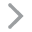

In [11]:
r.text

In [ ]:

bs_obj = get_bs_obj_from_url(http_url)